In [ ]:
# TODO priors for homopolymers seem off

In [20]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os
import pandas as pd
import seaborn.apionly as sns
import scipy.stats

# Params
PTHRESH = 0.8
PCOLORS = {
    "ALL": "black",
    1: "gray",
    2: "red",
    3: "gold",
    4: "blue",
    5: "green",
    6: "purple"
}
PLABELS = {
    "ALL": "ALL",
    1: "Mono-",
    2: "Di-",
    3: "Tri-",
    4: "Tetra-",
    5: "Penta-",
    6: "Hexa-"
}

# Load data
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"
DATADIR="/storage/mgymrek/ssc-denovos/denovos2/other-data"
MUTEADIR="/storage/mgymrek/ssc-denovos/mutea-results"
data = {}
data["ALL"] = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2.tab"), sep="\t")
for period in range(1, 7):
    data[period] = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2_period%s.tab"%period), sep="\t")
sgdp = pd.read_csv(os.path.join(DATADIR, "Gymrek_etal_SupplementalData1_v2.bed.gz"), sep="\t", usecols=range(4))
ssc = pd.read_csv(os.path.join(MUTEADIR, "ssc_mutea_auto_scaled.bed.gz"), sep="\t",
                  usecols=range(4), names=["#chrom","start","end","est_logmu_ml_ssc"])

# Outputs
OUTPATH = "pdfs"
PREFIX = "Figure1"

Populating the interactive namespace from numpy and matplotlib


In [72]:
# Calculate expected per family
families = [] 
expected_u = []
observed_u = []
expected_rates_u = []
observed_rates_u = []
periods = []

allfams = list(set(data["ALL"]["family"]))
for period in data.keys():
    bychild = data[period]
    bychild["prior_sum_scaled"] = bychild["prior_sum"]
    for f in allfams:
        try:
            exp_u = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==0)]["prior_sum_scaled"].values[0]
        except: exp_u = 0
        try:
            obs_u = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==PTHRESH)]["numutations"].values[0]
        except: obs_u = 0
        total = bychild[(bychild["family"] == f) & (bychild["status"]==1) & (bychild["pthresh"]==0)]["numutations"].values[0]
        exp_r_u = exp_u*1.0/total
        obs_r_u = obs_u*1.0/total
        expected_u.append(exp_u)
        observed_u.append(obs_u)
        expected_rates_u.append(exp_r_u)
        observed_rates_u.append(obs_r_u)
        families.append(f)
        periods.append(period)

pdata = pd.DataFrame({
    "family": families,
    "exp_u": expected_u,
    "obs_u": observed_u,
    "exp_rate_u": expected_rates_u,
    "obs_rate_u": observed_rates_u,
    "period": periods
})

# Figure 1B: Compare to MUTEA

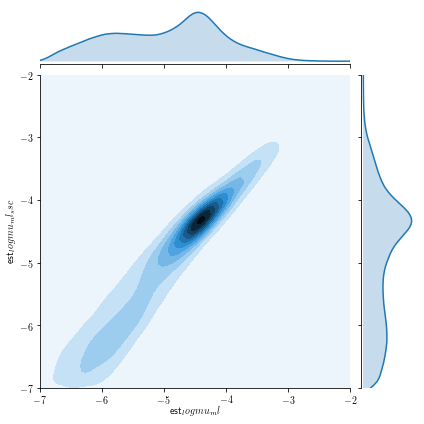

In [39]:
mutea = pd.merge(ssc, sgdp, on=["#chrom","start"])
mutea2 = mutea[(mutea["est_logmu_ml"]>-7) & (mutea["est_logmu_ml_ssc"]>-7) &
              (mutea["est_logmu_ml"]<-1) & (mutea["est_logmu_ml_ssc"]<-1)]
sns.jointplot(mutea2["est_logmu_ml"], mutea2["est_logmu_ml_ssc"], kind='kde', stat_func=None,
              xlim=(-7,-2), ylim=(-7,-2))
plt.savefig(os.path.join(OUTPATH, "%s_SSCvSGDP.png"%PREFIX)) # PNG since it's huge. update text in Illustrator
plt.show()

In [42]:
scipy.stats.pearsonr(mutea["est_logmu_ml"], mutea["est_logmu_ml_ssc"])

(0.8723608325984572, 0.0)

# Figure 1C: Number of denovos per family

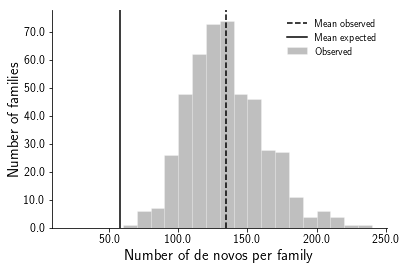

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
bins = np.arange(20, 250, 10)
ax.hist(pdata[pdata["period"]=="ALL"]["obs_u"], color="black", alpha=0.25,
        edgecolor="white", bins=bins, label="Observed");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of de novos per family", size=15)
ax.set_ylabel("Number of families", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)

# Mean observed, expected
mean_obs = np.mean(pdata[pdata["period"]=="ALL"]["obs_u"])
mean_exp = np.mean(pdata[pdata["period"]=="ALL"]["exp_u"])
ax.axvline(x=mean_obs, linestyle="dashed", color="black", label="Mean observed")
ax.axvline(x=mean_exp, color="black", label="Mean expected");
ax.legend(loc="upper right", frameon=False);
fig.savefig(os.path.join(OUTPATH, "%s_numperfamily.pdf"%PREFIX))

# Figure 1D: Mutation rate by period

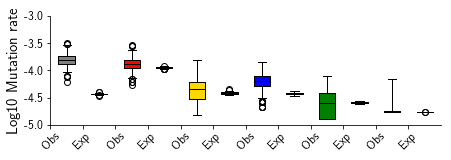

In [109]:
boxdata = []
colors = []
labels = []
for period in list(range(1, 7)):
    d = pdata[(pdata["period"].apply(str)==str(period))]
    boxdata.append(list(d["obs_rate_u"].apply(np.log10)))
    boxdata.append(list(d["exp_rate_u"].apply(np.log10)))
    colors.append(PCOLORS[period])
    colors.append(PCOLORS[period])
    labels.append("Obs")
    labels.append("Exp")
fig = plt.figure()
fig.set_size_inches((7, 2))
ax = fig.add_subplot(111)
bp = ax.boxplot(boxdata);
plt.setp(bp["medians"], color="black")
for i in range(len(colors)):
    box = bp["boxes"][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    boxPolygon = Polygon(boxCoords, facecolor=colors[i])
    ax.add_patch(boxPolygon)
ax.set_ylim(bottom=-5, top=-3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([item-0.5 for item in range(1, len(boxdata)+1)])
ax.set_xticklabels(labels, rotation=45, size=12);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_ylabel("Log10 mutation rate", size=15);
fig.savefig(os.path.join(OUTPATH, "%s_ratebyperiod.pdf"%PREFIX))